<a href="https://colab.research.google.com/github/nepslor/teaching/blob/main/TimeSeriesForecasting/solutions/inducing_stationarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seasonally adjusted data - an example
The mortality data [recently published](https://www.nature.com/articles/s41597-021-01019-1) by the [Human Mortality Database](https://www.mortality.org/) can be used to explore seasonality in mortality rates as fatalities / 100000 . Mortality rates are known to be seasonal due to temperatures and other weather-related effects (Healy 2003). In the folloing cells we will use STL decomposition to decompose these time series for different countries.




In [2]:
from statsmodels.tsa.seasonal import STL
import pandas as pd 
import matplotlib.pyplot as plt
stmf = pd.read_csv("https://www.mortality.org/File/GetDocument/Public/STMF/Outputs/stmf.csv",skiprows=1)

The following code just adds a DatetimeIndex to the data, from the year and the week columns

In [3]:
stmf.index = pd.DatetimeIndex(pd.DatetimeIndex(stmf['Year'].apply(lambda x: '{}-01-01'.format(x), 0)) + pd.to_timedelta( stmf['Week'].apply(lambda x: '{}d'.format(x * 7), 0)))
stmf.head()

,CountryCode,Year,Week,Sex,D0_14,D15_64,D65_74,D75_84,D85p,DTotal,R0_14,R15_64,R65_74,R75_84,R85p,RTotal,Split,SplitSex,Forecast
2015-01-08,AUS,2015,1,m,17.166833,358.833167,250.0,436.0,413.0,1475.0,0.000386,0.002373,0.013133,0.045643,0.127992,0.006484,1,0,0
2015-01-08,AUS,2015,1,f,13.968728,199.031272,183.0,350.0,704.0,1450.0,0.000332,0.001309,0.009350,0.031185,0.125849,0.006289,1,0,0
2015-01-08,AUS,2015,1,b,31.135561,557.864439,433.0,786.0,1117.0,2925.0,0.000360,0.001840,0.011215,0.037832,0.126633,0.006386,1,0,0
2015-01-15,AUS,2015,2,m,17.473384,334.526616,255.0,386.0,422.0,1415.0,0.000393,0.002212,0.013395,0.040409,0.130781,0.006220,1,0,0
2015-01-15,AUS,2015,2,f,11.490405,186.509595,162.0,322.0,675.0,1357.0,0.000273,0.001227,0.008277,0.028690,0.120665,0.005886,1,0,0


Since the data of a given year-week is splitted over multiple lines due to the presence of the sex attribute, we need to define an auxiliary function to get the aggregated value regardless of the sex. 

We additionally define a function returning the matrix form of the data: a dataframe whose rows corresponds to the year and columns to the day of observations.

In [22]:
def get_national_obs(data, cc='ITA'):
  """
  Get death rate for a given country
  """
  data = stmf.loc[stmf['CountryCode'] == cc, ['Week', 'Year', 'RTotal']]
  return data.groupby(data.index).sum()['RTotal']
  
def get_matrix_form(y):
  """
  Get death rate for a given country, in matrix format (year, week)
  """
  y = pd.concat([y, pd.Series(y.index.year, name='Year', index=y.index), 
                 pd.Series(y.index.dayofyear, name='Day', index=y.index)], axis=1)
  y = y.loc[(y.Day>7) & (y.Year<2023)]
  return y.pivot(index='Year', columns='Day', values='RTotal').T
  


<AxesSubplot:>

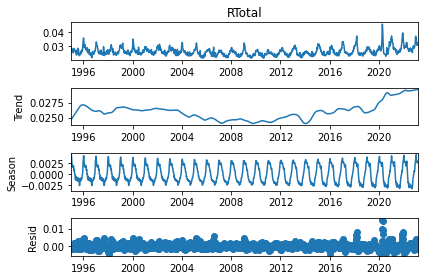

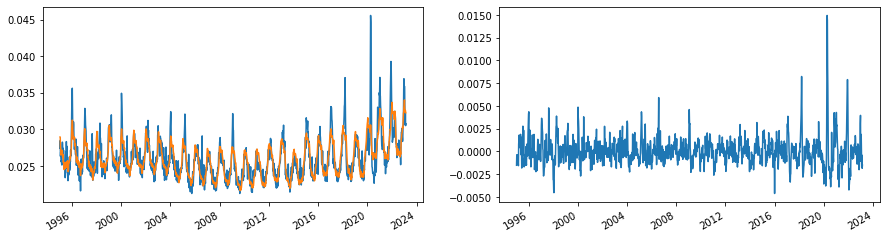

In [18]:
y = get_national_obs(stmf, 'NLD')
stl = STL(y, seasonal=53, period=52)
res = stl.fit()

fig = res.plot()
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
res.observed.plot(ax=ax[0])
(res.trend+res.seasonal).plot(ax=ax[0])
(res.resid).plot(ax=ax[1])


Let's have a look at the seasonal plot of the time series

Text(0.5, 1.0, 'seasonal plot')

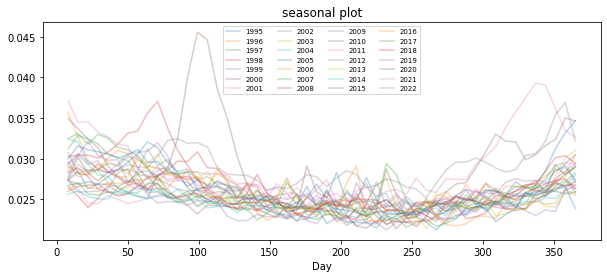

In [60]:
y_mat = get_matrix_form(get_national_obs(stmf,cc='NLD'))

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
y_mat.plot(alpha=0.3, ax=ax)
plt.legend(fontsize='x-small', ncol=4)
ax.set_title('seasonal plot')

## ❓Write a simple seasonal-trend decomposition
A simple seasonal-trend decomposition can be achieved using the following method:
1. trend: use a lagged moving average of the original signal
2. seasonal: median season of the detrended signal

you can use the `get_matrix_form` and `get_national_obs` functions to do this.

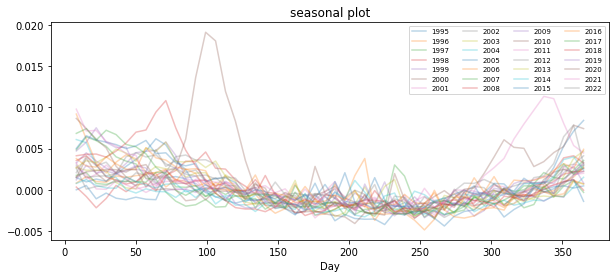

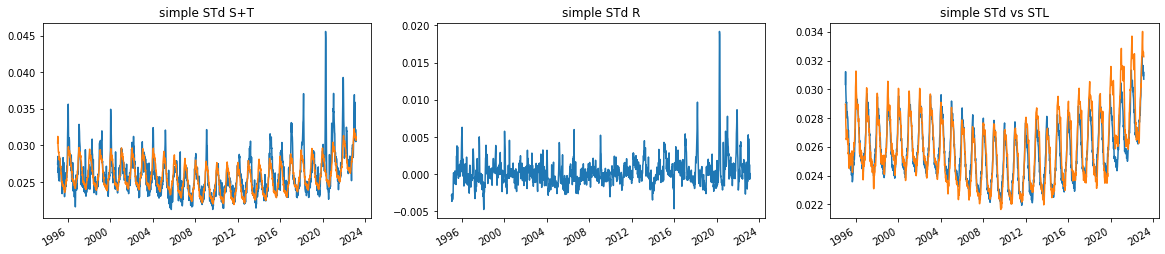

In [57]:
import numpy as np

lagged_mav = lambda x, k: x.rolling('{}d'.format(k)).mean()

def simple_std(stmf):
  """ 
  A simple function that returns trend and seasonal component. The trend is 
  obtained using the lagged_mav function, while the seasonal component is the 
  daily median of the detrended profile.  
  """
  trend = lagged_mav(get_national_obs(stmf,cc='NLD'), 365*3)
  y_mat = get_matrix_form(get_national_obs(stmf,cc='NLD')-trend)
  season = y_mat.quantile(0.5, axis=1)
  y_seasonal = pd.Series(np.tile(season.values, y_mat.shape[0])[:len(y)], index=y.index)
  return trend, y_seasonal

trend, y_seasonal = simple_std(stmf)


fig, ax = plt.subplots(1, 3, figsize=(20, 4))
y.plot(ax=ax[0])
(y_seasonal+trend).plot(ax=ax[0])
(y-y_seasonal-trend).plot(ax=ax[1])
(trend + y_seasonal).plot(ax=ax[2])
(res.trend + res.seasonal).plot(ax=ax[2])
ax[0].set_title('simple STd S+T')
ax[1].set_title('simple STd R')
ax[2].set_title('simple STd vs STL');

# Forecasting with STL decomposition
Given the STL decomposiion 
$$y_t=S_t+T_t+R_t$$
we can assume that the seasonal component is slow changing, and repeats itself almost exactly. This means that we can use the seasonal naive method we've seen in the last lesson to forecast the seasonal component and then use a forecasting model to just predict $T_t+R_t$. 
$$
\begin{align}
\hat{y}_{T+h}&= \hat{S}_{T+h} + f(T_T+R_T) \qquad \ \text{forecasting model + seasonal forecast}\\
\hat{S}_{T+h}&=\hat{S}_{T-k} \qquad\qquad\qquad\qquad \text{seasonal naive}
\end{align}
$$

where $k=m-h+m\lfloor(h-1) / m\rfloor$

\\
<div>
<img src="https://raw.githubusercontent.com/nepslor/teaching/main/TimeSeriesForecasting/figs/Baregg_tunnel.png" width="400" align="right"/>
</div>

Tunnel Traffic is a time series describing the number of vehicles traveling through the Baregg Tunnel in Switzerland each day from November 2003 to November 2005.




            NumVehicles
Day                    
2003-11-01       103536
2003-11-02        92051
2003-11-03       100795
2003-11-04       102352
2003-11-05       106569


<AxesSubplot:xlabel='Day'>

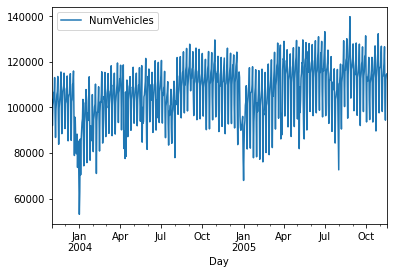

In [7]:
data = pd.read_csv('https://raw.githubusercontent.com/nepslor/teaching/main/TimeSeriesForecasting/data/tunnel.csv', parse_dates=True, index_col=0)
print(data.head())
data.plot()

We start by decomposing the data with the STL and plotting it

<AxesSubplot:xlabel='Day'>

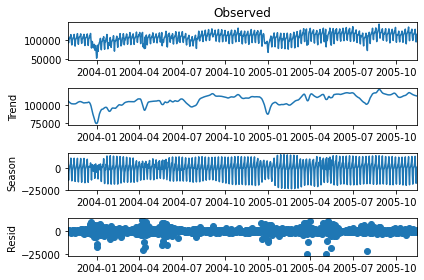

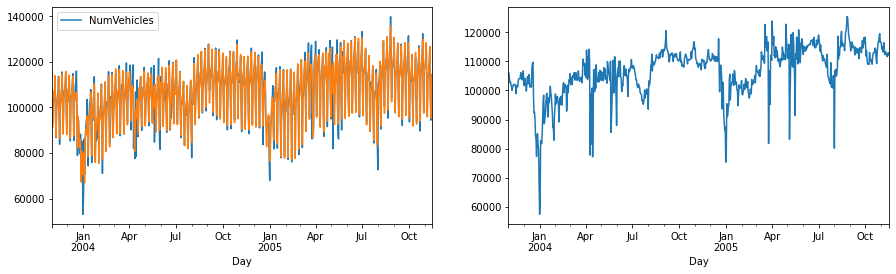

In [8]:
stl = STL(data, seasonal=7)
res = stl.fit()

fig = res.plot()
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
res.observed.plot(ax=ax[0])
(res.trend+res.seasonal).plot(ax=ax[0])
(res.trend+res.resid).plot(ax=ax[1])

In [9]:

def get_hankel(df, embedding=3):
  return pd.concat([df.shift(-l) for l in range(embedding)], axis=1).iloc[:-embedding]


class LinearForecaster:
  """
  A simple linear forecaster: retrieves the signal's Hankel matrix of 
  the requested embedding and fits a linear regression on future values.  
  """
  def __init__(self, steps_ahead=1, embedding=3):
    self.steps_ahead = steps_ahead
    self.embedding = embedding
    self.theta = None
    self.mean = None
    self.std = None

  def fit(self, y0):
    y = y0.copy()
    self.mean = np.array(y.mean())
    self.std = np.array(y.std())
    y_embedded = get_hankel(y, self.steps_ahead + self.embedding)
    x = y_embedded.iloc[:, :self.embedding].values/self.std-self.mean
    target = y_embedded.iloc[:, self.embedding:].values
    self.theta = np.linalg.pinv(x.T@x)@(x.T@target)
    return self

  def predict(self, df):
    x = df.iloc[-self.embedding:].values.reshape(1, -1)/self.std-self.mean
    preds = x @ self.theta
    return pd.DataFrame(preds.ravel(), index=df.iloc[-self.steps_ahead:].index + pd.to_timedelta('{}d'.format(self.steps_ahead)), columns=['y_hat_lin'])


class STLLinearForecaster:
  def __init__(self, seasonality=13, linear_embedding=3):
    self.seasonality = seasonality
    self.linear_embedding = linear_embedding
    self.rt_model = LinearForecaster(steps_ahead=seasonality, embedding=linear_embedding)
    self.seasonal_component = None

  def fit(self, df):
    # STL decomposition of the signal
    stl = STL(df, seasonal=self.seasonality)
    res = stl.fit()
    df_rt = res.trend+res.resid
    self.rt_model.fit(df_rt)
    self.seasonal_component = res.seasonal
    return self

  def predict(self, df):
    s_t = self.seasonal_component.iloc[-self.seasonality:]
    rt_t = self.rt_model.predict(df)
    return pd.DataFrame(s_t.values + rt_t.values.ravel(), index=df.iloc[-self.seasonality:].index + pd.to_timedelta('{}d'.format(self.seasonality)), columns=['y_hat_stl'])

linear        0.054139
stl_linear    0.049144
dtype: float64

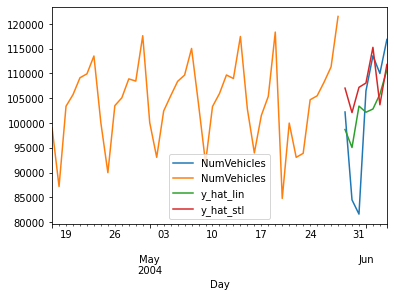

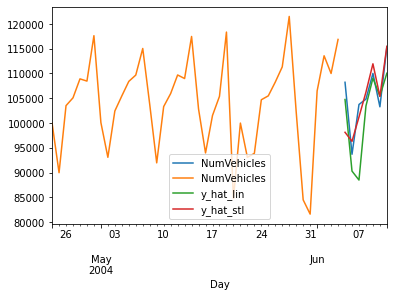

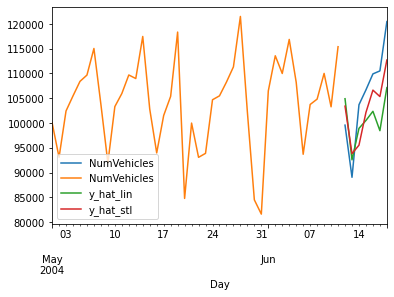

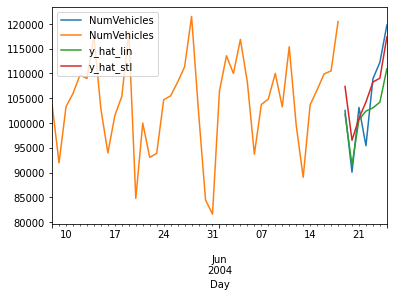

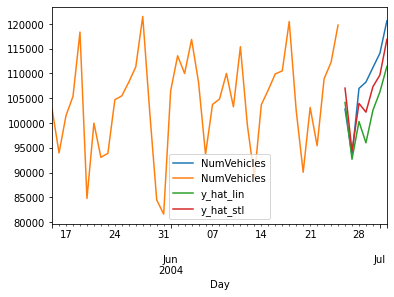

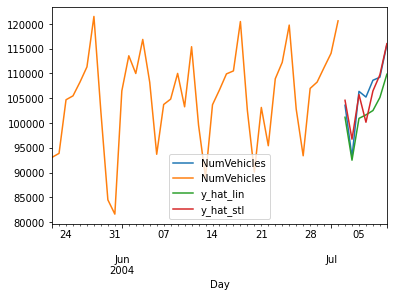

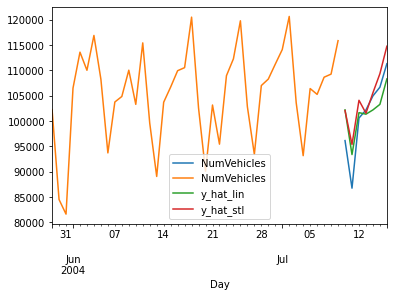

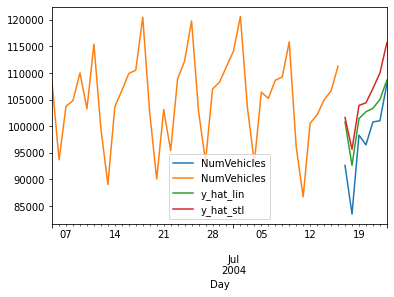

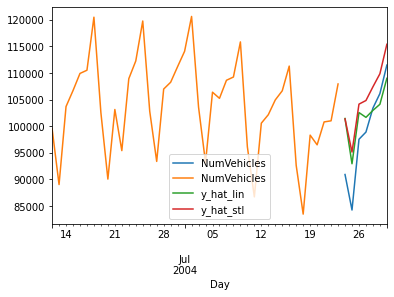

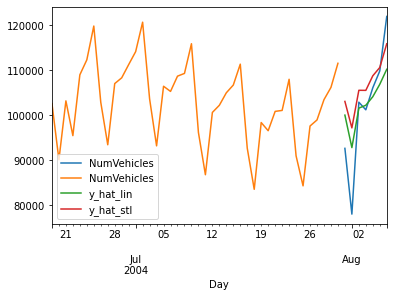

In [10]:

steps_ahead = 7
linear_model = LinearForecaster(steps_ahead=steps_ahead, embedding=steps_ahead)
stl_model = STLLinearForecaster(seasonality=steps_ahead, linear_embedding=steps_ahead)
forecasters = [linear_model, stl_model]
names = ['linear', 'stl_linear']
nmae = lambda x, y: np.mean(np.abs(x - y)) / np.mean(np.abs(y))


scores = {}
for i in range(10):
    k = 7 * i + 7 * 30
    data_tr, data_te = data.iloc[:k], data.iloc[k:k + steps_ahead]
    preds = {n: f.fit(data_tr).predict(data_tr) for n, f in zip(names, forecasters)}
    scores[i] = {n: nmae(data_te.values, p.values) for n, p in preds.items()}
    # plot
    fig, ax = plt.subplots(1, 1)
    data_te.plot(ax=ax)
    data.iloc[k - 7 * 6:k].plot(ax=ax)
    [p.plot(ax=ax) for p in preds.values()]

    
pd.DataFrame(scores).mean(axis=1)